# 2_Prepare_Training_Data notebook

# Summary

The purpose of this notebook is primarily for exploring different techniques to use to process data before it can be fed to the final model. The technique that provides the best result is then used to process the training data before it can be fed to our final model in the `4_Final_Model_Training_Prediction.ipynb`

This notebook is for preparing the training data for future model exploration. 
The previous notebook has created a cleaned data file with lemmatized description. 
We will attempt to use different vectorization and encoding method to prepare various set of input variables for our machine learning models.

The embeddings created here will be used as an input to the notebook `3_Model Exploration.ipynb`.



# Libraries

In [39]:
import pandas as pd
import nltk
from nltk.stem.porter import PorterStemmer
import pandas as pd
import sys
import re
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import string
from nltk.corpus import stopwords
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import seaborn as sns
from gensim.parsing.preprocessing import remove_stopwords
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sneharaj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sneharaj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import nltk
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()
from tqdm import tqdm

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer

In [5]:
from typing import List
from keras.preprocessing.text import text_to_word_sequence

In [6]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
import warnings
warnings.filterwarnings("ignore")

# Load the Data

The `final_cleaned_data.csv` is the file produced by the notebook: `1_Data_Cleaning_Feature_Creation.ipynb`

In [8]:
# Option to upload the file with pickle files
# import pickle
# with open('final_cleaned_data.pkl', 'rb') as f:
#     behold_prod = pickle.load(f)

   

In [9]:
behold_prod = pd.read_csv('final_cleaned_data.csv')

# Choice of Lemma VS Stemming

We choose to use the lemmatized description as our corpus to prepare the training data. 

Although it is not necessary to understand the sentiment in the product description, the part of speech information can help us differentiate the way of phrasing or naming things used by a certain brands. In the product description, especially clothing description, there are similar words or expression used frequently by one brand, but may be not used by other brands. 

The lemmatized description can help us find and understand those patterns. Therefore, we chose to go ahead with the lemmatized description. 


# Count Vectorisation

In [10]:
behold_prod['lemmatized_description'].fillna('Blank',inplace=True)

In [38]:
countvectorizer = CountVectorizer(stop_words="english", binary=True, min_df=0.001)

X_cv = countvectorizer.fit_transform(behold_prod['lemmatized_description'].astype(str))



In [12]:
X_cv.shape

(61355, 2724)

# PCA on Count Vectoriser

As you can see the vectorized DataFrame has 2754 columns, this high dimensionality is not good for future modeling. Therefore we applied SVD on the `X_cv` dataset.

> **(Singular Value Decomposition) SVD** performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, it can work with sparse matrices efficiently.

Text(0, 0.5, 'Cumulative Explained variance')

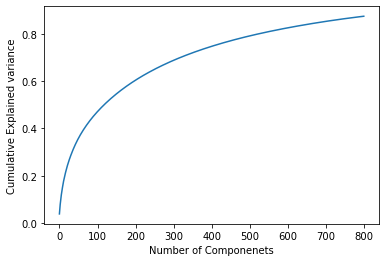

In [13]:
svd_cv = TruncatedSVD(n_components=800, n_iter=7, random_state=42)
svd_cv.fit(X_cv)
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.cumsum((svd_cv.explained_variance_ratio_)))
plt.xlabel("Number of Componenets")
plt.ylabel("Cumulative Explained variance")

In [14]:

svd_cv=TruncatedSVD(n_components=500)
princ_comps_cv=svd_cv.fit_transform(X_cv)

# Feature Encoding

Although we have created many features, we don't use all of them in the modeling. 
We only use those which can differetiate brands. 
For instance, `fabric`, `made_in` and `wash_type` are kept identical for one brand. However, features such as `color`, `category` are not so useful to identify brands. 

We conduct **one-hot** encoding on our selected features. 
Previously we also tried to use target encoding to encode the features. However, it creates too many columns and brings high dimensionality to the dataset. Therefore we decided to use onehot encoding rather than target encoding.

In [15]:
# Filling in the null values
behold_prod.fillna('Blank',inplace=True)

In [16]:
# One-hot encoding
enc=OneHotEncoder(handle_unknown='ignore')

for c in ['Made_In','final_fabric','Handcrafted','True_To_Size']:
    enc.fit(behold_prod[c].values.reshape(-1,1))
    FeatureInput=enc.transform(behold_prod[[c]]).toarray()
    if c=='Made_In':
        cat_feat_array=FeatureInput
    else:
        cat_feat_array=np.concatenate([FeatureInput,cat_feat_array],axis=1)

In [17]:
# Checking shape of the encodings
cat_feat_array.shape

(61355, 44)

In [18]:
behold_prod.columns

Index(['Unnamed: 0', 'product_id', 'brand', 'brand_category', 'name',
       'details', 'created_at', 'brand_canonical_url', 'description',
       'brand_description', 'brand_name', 'product_active',
       'is_womens_clothing', 'is_children_clothing', 'is_men_clothing',
       'user_type', 'one_piece_check', 'shoe_check', 'handbag_check',
       'scarf_check', 'top_check', 'acc_check', 'linen_check', 'bottom_check',
       'lingerie_check', 'max_value_cat', 'final_category', 'color_list',
       'colors', 'n_colors', 'final_color', 'care_list', 'wash_type',
       'is_dry_clean', 'is_hand_wash', 'is_machine_wash_cold',
       'is_machine_wash', 'is_tumble_dry', 'is_not_bleach', 'fabric_list',
       'fabrics', 'n_fabric', 'final_fabric', 'Made_In', 'Occasion',
       'Deadstock', 'Handcrafted', 'True_To_Size', 'lemmatized_description',
       'label'],
      dtype='object')

> The feature Washtype has more than one value for each record, therefore we need to encode it separately using the relevent boolean variables. 

In [19]:
washtype_df = behold_prod[['is_dry_clean', 'is_hand_wash', 'is_machine_wash_cold',
       'is_machine_wash', 'is_tumble_dry', 'is_not_bleach']]
washtype_array = washtype_df.to_numpy()

In [20]:
washtype_array.shape

(61355, 6)

In [21]:
cat_feat_array=np.concatenate([washtype_array,cat_feat_array],axis=1)

In [22]:
cat_feat_array.shape

(61355, 50)

# PCA on Encoded Features

Principal component analysis on the feature array allows us to see how much variance is captured by the top 'n' features.

Text(0, 0.5, 'Cumulative Explained variance')

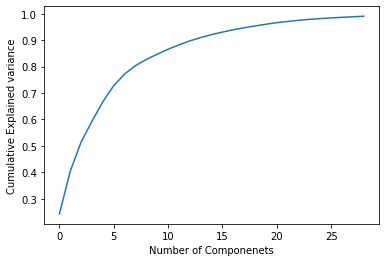

In [23]:
pca=PCA(n_components=0.99,svd_solver="full")
pca.fit(cat_feat_array)

plt.plot(np.cumsum((pca.explained_variance_ratio_)))
plt.xlabel("Number of Componenets")
plt.ylabel("Cumulative Explained variance")

In [24]:
pca=PCA(n_components=20) #  around 90% captured by 20 features
features_princ_comps=pca.fit_transform(cat_feat_array)

# TF-IDF

TF-IDF on the lemmatized description and we visualize the top scoring n-grams

<AxesSubplot:>

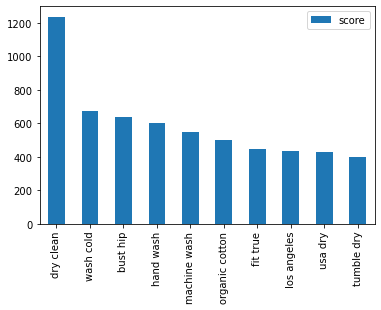

In [25]:
corpus = list(behold_prod['lemmatized_description'].astype(str).values)

i = 2

vectorizer = TfidfVectorizer(ngram_range=(i,i),token_pattern=r'\b[a-z]{3,}\b',
                            max_df=0.3,min_df=.001)
corpus =  corpus

X_tfidf = vectorizer.fit_transform(corpus)
terms = vectorizer.get_feature_names()
tf_idf = pd.DataFrame(X_tfidf.toarray().transpose(), index=terms)

tf_idf = tf_idf.sum(axis=1)
score = pd.DataFrame(tf_idf, columns=["score"])
score.sort_values(by="score", ascending=False, inplace=True)
score.head(10).plot(kind='bar')

# PCA on TF-IDF

We visualize the cumulative variance explained by the top 800 elements for each row. We see that the top 800 capture around 80% of the variance.

In [26]:
svd = TruncatedSVD(n_components=800, n_iter=7, random_state=42)
svd.fit(X_tfidf)


TruncatedSVD(n_components=800, n_iter=7, random_state=42)

Text(0, 0.5, 'Cumulative Explained variance')

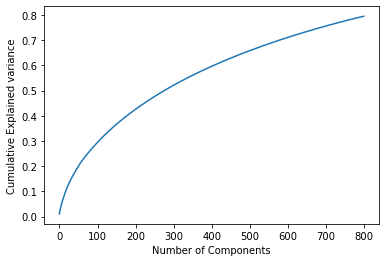

In [27]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.cumsum((svd.explained_variance_ratio_)))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained variance")

In [28]:

svd=TruncatedSVD(n_components=800)
princ_comps_tfidf=svd.fit_transform(X_tfidf)

# Word Tokenization

Word Tokenization is a preparation step to help our deep learning alorithms.  

In [29]:
tokenizer = Tokenizer(num_words=10000,oov_token='UNKNOWN_TOKEN')
tokenizer.fit_on_texts(behold_prod['lemmatized_description'].astype(str))


In [30]:
vocab_size = int(len(tokenizer.word_index) * 1.3)
print(f"Vocab size is {vocab_size} unique tokens.")

Vocab size is 45279 unique tokens.


In [31]:
tokenizer.word_index

{'UNKNOWN_TOKEN': 1,
 'cotton': 2,
 '100': 3,
 'dry': 4,
 'style': 5,
 'feature': 6,
 'leather': 7,
 'wash': 8,
 'fabric': 9,
 'sleeve': 10,
 'blank': 11,
 'clean': 12,
 'length': 13,
 'dress': 14,
 'hand': 15,
 'pocket': 16,
 'design': 17,
 'print': 18,
 'usa': 19,
 'soft': 20,
 'line': 21,
 'hem': 22,
 'look': 23,
 'perfect': 24,
 'classic': 25,
 'care': 26,
 'true': 27,
 'shoulder': 28,
 'button': 29,
 'piece': 30,
 'closure': 31,
 'silhouette': 32,
 'body': 33,
 'strap': 34,
 'black': 35,
 'cold': 36,
 'fit': 37,
 'hip': 38,
 'pair': 39,
 'bust': 40,
 'skirt': 41,
 'color': 42,
 'material': 43,
 'stretch': 44,
 'tie': 45,
 'pant': 46,
 'cut': 47,
 'import': 48,
 'neckline': 49,
 'short': 50,
 'low': 51,
 'ruffle': 52,
 '510': 53,
 'polyester': 54,
 'heel': 55,
 '12': 56,
 'day': 57,
 'machine': 58,
 'neck': 59,
 'wool': 60,
 'silk': 61,
 '4': 62,
 '34': 63,
 'denim': 64,
 'lightweight': 65,
 'italy': 66,
 'finish': 67,
 'add': 68,
 'shape': 69,
 'shirt': 70,
 'knit': 71,
 'feel': 7

# Integer Encoding of Docs and padding

This `texts_to_sequences` encoding will give us a list of integer sequences encoding the words in sentence.

In [32]:
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

In [33]:
# integer encode the documents
docs=behold_prod['lemmatized_description'].astype(str)
encoded_docs = integer_encode_documents(docs, tokenizer)

In [34]:
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

In [35]:
max_length = get_max_token_length_per_doc(docs)
max_length

374

In [36]:
max_length=300
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print("Padded docs:", padded_docs)

Padded docs: [[  75 2773   70 ...    0    0    0]
 [2113   14   52 ...    0    0    0]
 [2345  241  545 ...    0    0    0]
 ...
 [ 139    1  800 ...    0    0    0]
 [ 139 7737  800 ...    0    0    0]
 [ 139    1  800 ...    0    0    0]]


# Loading Pretrained Embeddings

In [37]:
f = open('glove.6B.100d.txt',encoding='utf-8')
embeddings_index={}
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

FileNotFoundError: [Errno 2] No such file or directory: 'glove.6B.100d.txt'

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [ ]:
# X_all_1:np.concatenate([X_cv.toarray(),features_princ_comps],axis=1)
cv_featPca = np.concatenate([X_cv.toarray(),features_princ_comps],axis=1)
# X_all_2:np.concatenate([princ_comps_cv,cat_feat_array],axis=1)
cvPca_feat = np.concatenate([princ_comps_cv,cat_feat_array],axis=1)
# X_all_3:np.concatenate([princ_comps_cv,features_princ_comps],axis=1)
cvPca_featPca = np.concatenate([princ_comps_cv,features_princ_comps],axis=1)
# X_all_4:np.concatenate([princ_comps_tfidf,features_princ_comps],axis=1)
tfidfPca_featPca = np.concatenate([princ_comps_tfidf,features_princ_comps],axis=1)

# Writing pickle files

In [ ]:
# save data 
import pickle

# cat_feat_array.pkl is the array of encoded features
with open('cat_feat_array.pkl', 'wb') as f:
    pickle.dump(cat_feat_array, f)

# features_princ_comps.pkl is pca on the encoded feature array (cat_feat_array.pkl)
with open('features_princ_comps.pkl', 'wb') as f:
    pickle.dump(features_princ_comps, f)

#=====================================================================   
# X_cv.pkl is the Countvertorized lemmatized descriptions
with open('X_cv.pkl', 'wb') as f:
    pickle.dump(X_cv, f)  
# princ_comps_cv.pkl is the pca on Countvertorized lemmatized descriptions(X_cv.pkl)
with open('princ_comps_cv.pkl', 'wb') as f:
    pickle.dump(princ_comps_cv, f)

#=====================================================================   

 # X_tfidf.pkl is the tfidf vectorized lemmatized description
with open('X_tfidf.pkl', 'wb') as f:
    pickle.dump( X_tfidf, f)  
 # princ_comps_tfidf.pkl is the tfidf vectorized lemmatized description(X_tfidf.pkl) with PCA
with open('princ_comps_tfidf.pkl', 'wb') as f:
    pickle.dump(princ_comps_tfidf, f)  

#=====================================================================  

## combinations of the above data, to make different set of training data

# cv_featPca_1.pkl is the countvectorized lemma description + encoded feature array with PCA
with open('cv_featPca_1.pkl', 'wb') as f:
    pickle.dump(cv_featPca, f)
# cvPca_feat_2.pkl is the countvectorized lemma description with PCA + encoded feature vector without PCA
with open('cvPca_feat_2.pkl', 'wb') as f:
    pickle.dump(cvPca_feat, f)     
# cvPca_featPca_3.pkl is the the countvectorized lemma description with PCA + encoded feature array with PCA
with open('cvPca_featPca_3.pkl', 'wb') as f:
    pickle.dump(cvPca_featPca, f)   
# tfidfPca_featPca_4.pkl is the tfidf vectorized lemma description with PCA + encoded feature array with PCA
with open('tfidfPca_featPca_4.pkl', 'wb') as f:
    pickle.dump(tfidfPca_featPca, f)

#===================================================================== 
    
 # padded_docs.pkl is the lemmatized_description after integer encoding and padding 
with open('padded_docs.pkl', 'wb') as f:
    pickle.dump(padded_docs, f)

In [ ]:
    
 # embedding_matrix.pkl is the loaded pretrained embeddings from GloVe
with open('embedding_matrix.pkl', 'wb') as f:
    pickle.dump(embedding_matrix, f)



In [ ]:
#tokenizer_word_index.pkl is the tokenized lemma description 
with open('tokenizer_word_index.pkl', 'wb') as f:
    pickle.dump(tokenizer.word_index, f)
